In [161]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import tensorflow.keras as keras
from noise_generator.noisegen import NoiseHandling

In [162]:
%load_ext autoreload
%autoreload 2
from audio_process.fft import expand_image_dims, train_img_generate
from Image_Generator_helpers import  DataSets, set_paths, global_path
from data_filters import min_n_letters_raw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
model_velocity = keras.models.load_model('saved_model_velocity_raw_23')
model_regression = keras.models.load_model('saved_model_regresssion_raw')
model_categorical = keras.models.load_model('saved_model_categorical_raw')
model_binary = keras.models.load_model('saved_model_raw_binary')
TRAINING_IMAGE_DIMENSIONS = (5, 1400)
NODGE_IMAGE_PIXEL_AMOUNT = 5 #Push the image to the left to adjust for incorrect position prediction
CATEGORICAL_IMAGE_CROPPED_WIDTH = TRAINING_IMAGE_DIMENSIONS[1] - 1250 #Cropped with during traing of categorical prediction model"
FFT_JUMP = 64
MEAN_TEMPO_OF_TRAINING_DATA = (18 + 25) / 2 # The mean tempo of the training data tempis 

In [164]:
def show_image(img, width, position = []):
    plt.figure(figsize=(30,5))
    plt.xlim(0, width)
    if len(position) != 0:
        plt.xticks(position)    
    plt.imshow(img)
    plt.show()

# insert an image into an empty image at start and en position
def insert_image(empty_image, image, start_pos, end_pos):
    empty_image[:, start_pos:end_pos] = image
    return empty_image

In [165]:
Cnoise=NoiseHandling()
Cnoise.SetFrequencies(6000,2200,200)
Cnoise.noise_rng
# From 0 = no noise to -15 = significant noise
# INFO:  table of SNRdb vs. digit in version\n",
# ver \t 0   1   2  3  4\n",
# SNRdB   30  10  5  2  0\n",

def apply_noise(signal, signal_to_noise_ratio_db):
    signal_noise, some_noise = Cnoise.addNoise(signal, signal_to_noise_ratio_db)
    return signal_noise

In [166]:
# set_obj = DataSets(set_paths, global_path, [min_n_letters_raw(3)])
# set_obj.csv_files

Add noise to image

In [167]:



# # start_time = time.time()

# random_sets = [set_obj.get_random() for n in range(128)]
# random_signals = [set_obj.get_item(random_set) for random_set in random_sets]
# signals_shiftet = [np.insert(signal, 0, np.zeros(0), axis=0) for signal in random_signals] ## prepend with 12840 zeros to align with image pixel 200
# signal_noises = [apply_noise(signal, 5) for signal in signals_shiftet]
# images_noise = [train_img_generate(signal_noise, FFT_JUMP) for signal_noise in signal_noises]

# print(type(images_noise[0]))

# # print("--- %s seconds ---" % (time.time() - start_time))

# for idx,img in enumerate(images_noise):
#     print(f"Word nr : {idx}")
#     print(random_sets[idx].csv_row.WORD)
#     print("First image:")
#     show_image(img, 0, 250)
#     print(img)
#     if (idx > 5):
#         break


In [168]:
ORIG_AUDIO_FILE_NAME = 'training_data/MorseTrainSet_23/AUDIO23/BOPAEWITAVZSEE_10400_23_010.wav'
# ORIG_AUDIO_FILE_NAME_2 = 'training_data/AUDIO18/AIAMOMCESHBBK_09900_18_000.wav'

SampleRate, signal = wavfile.read(ORIG_AUDIO_FILE_NAME)

length = signal.shape[0] / SampleRate

print(signal.shape)
print(SampleRate)
print('length:', length, "seconds")



(34465,)
6000
length: 5.744166666666667 seconds


In [169]:
signal = np.float32(signal)
max = np.max(signal)
signal = signal / max

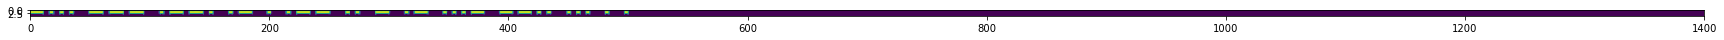

In [170]:
signal_to_noise_ratio_db = 30 # From 0 = no noise to -15 = significant noise
signal_noise = apply_noise(signal, signal_to_noise_ratio_db)
img_noise = train_img_generate(signal_noise, FFT_JUMP)

show_image(img_noise, 1400)

Velocity prediction

In [171]:
velocity_prediction = (model_velocity(expand_image_dims(img_noise))).numpy()[0][0] * 100
velocity_prediction

22.850950062274933

Generate new image with mean tempo of training data based on velocity prediction

In [172]:
fft_jump_tempo_coefficient = (MEAN_TEMPO_OF_TRAINING_DATA / velocity_prediction)
rescaled_jump = FFT_JUMP * fft_jump_tempo_coefficient
img_noise_rescaled = train_img_generate(signal_noise, rescaled_jump)

Check n-px ahead and determine signal activity

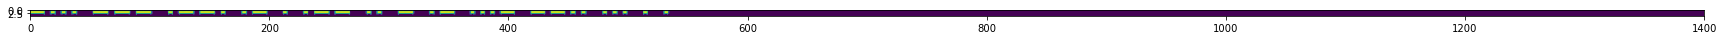

In [173]:
show_image(img_noise_rescaled, 1400)

Regression prediction to obtain first letter end position

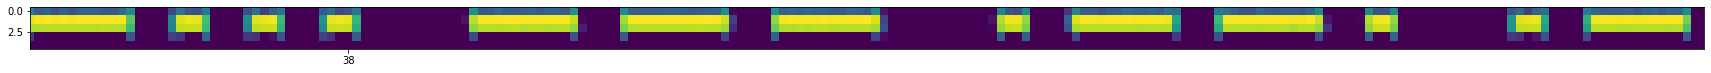

In [175]:
first_letter_position = model_regression(expand_image_dims(img_noise_rescaled)).numpy()[0][0] * 1400
show_image(img_noise_rescaled, 200, [int(first_letter_position)])
first_letter_position_nodged = first_letter_position + NODGE_IMAGE_PIXEL_AMOUNT


Prepare image for categorical prediction

In [ ]:
start_position = int(CATEGORICAL_IMAGE_CROPPED_WIDTH - first_letter_position_nodged)
image_with_categorical_cropped = insert_image(
    empty_image=np.zeros([5,150]), 
    image=img_noise_rescaled[:,:int(first_letter_position_nodged)], 
    start_pos=start_position, 
    end_pos= int(first_letter_position_nodged) + start_position
)

In [ ]:
print(image_with_categorical_cropped.shape)

(5, 150)


Categorical prediction

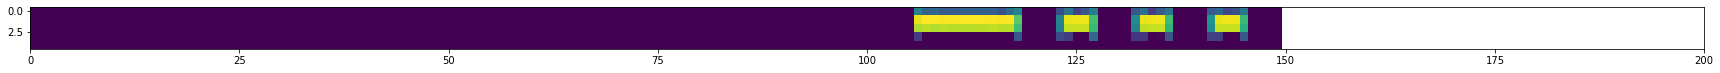

categorical prediction:  1


In [ ]:


categorical_prediction = model_categorical(expand_image_dims(image_with_categorical_cropped))
show_image(image_with_categorical_cropped, width=200)
print('categorical prediction: ', np.argmax(categorical_prediction))


43


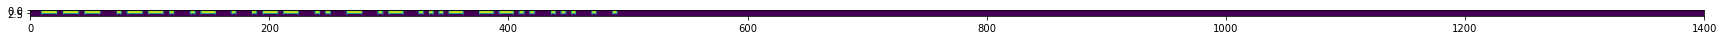

In [178]:

def left_shift_image(image, pos):
    print(pos)
    empty_image = np.zeros([5, 1400])
    empty_image[:, 0: 1400 - pos] = image[:, pos: 1400]
    return empty_image

shifted_image = left_shift_image(img_noise_rescaled, int(first_letter_position_nodged))

show_image(shifted_image, 1400)
